In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from helpers.graph import *
from helpers.geometry import *;
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload
%matplotlib notebook

In [2]:
# use cv2.pyrMeanShiftFiltering if filter = True
# sp – The spatial window radius.
# sr – The color window radius.
def generate_polygon_countour(image, filter=None, sp=None, sr=None):
    if filter:
        image = cv2.pyrMeanShiftFiltering(image, sp, sr)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, countours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    approxes = []
    for i, cnt in enumerate(countours):
        episilon = 0.01 * cv2.arcLength(cnt, True)
        approxes.append(cv2.approxPolyDP(cnt, episilon, True))
    return approxes

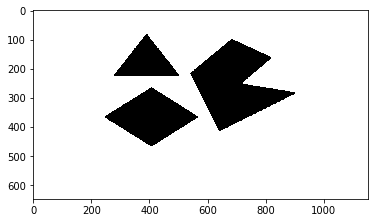

In [3]:
img = cv2.imread("new_paint.png")
plt.imshow(img)

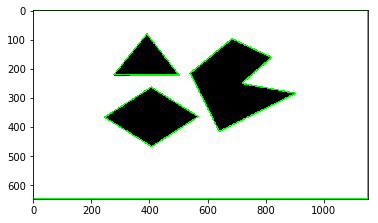

In [4]:
approxes = generate_polygon_countour(img)
for approx in approxes:
    img = cv2.drawContours(img, [approx], 0, (0,255,0), 3)
plt.imshow(img)

In [5]:
polygons = [np.squeeze(x) for x in approxes]

y_limit_lower = min([pt[1] for pt in polygons[0]])
y_limit_upper = max([pt[1] for pt in polygons[0]])

x_limit_lower = min([pt[0] for pt in polygons[0]])
x_limit_upper = max([pt[0] for pt in polygons[0]])

# boundary_basic certex order
boundary_basic = [[x_limit_lower, y_limit_lower], [x_limit_upper, y_limit_lower], [x_limit_upper, y_limit_upper], [x_limit_lower, y_limit_upper]]
obstacles_basic = polygons[1:]
source_basic, dest_basic = [[10, 10], [1000, 500]]

In [6]:
boundary_basic

[[0, 0], [1151, 0], [1151, 647], [0, 647]]

In [7]:
obstacles_basic

[array([[406, 264],
        [568, 365],
        [408, 468],
        [245, 367]], dtype=int32), array([[684,  98],
        [820, 162],
        [718, 251],
        [903, 285],
        [640, 416],
        [540, 216]], dtype=int32), array([[278, 221],
        [391,  81],
        [502, 223]], dtype=int32)]

In [8]:
def extract_vertex(_boundary, _source, _dest, _obstacles=None):
    boundary = [point(i[0], i[1]) for i in _boundary]
    source = point(_source[0], _source[1])
    dest = point(_dest[0], _dest[1])
    # Extract obstacles
#     obstacles = []
#     for i in raw_data[1:-1]:
#         obstacles.append()
    return boundary, source, dest

In [9]:
boundary, source, dest = extract_vertex(boundary_basic, source_basic, dest_basic)
obstacles = obstacles_basic

In [10]:
# Draw the obstacles and point the source and the destination----------------------------------------------
def draw_problem(boundary, obstacles, source, dest):
    bnd_x = [i.x for i in boundary]
    # add the x-value of the start point
    bnd_x.append(boundary[0].x)
    bnd_y = [i.y for i in boundary]
    # add the y-value of the start point
    bnd_y.append(boundary[0].y)


    # Draw the boundary
    plt.plot(bnd_x, bnd_y)

    poly_x = []
    poly_y = []
    for index, i in enumerate(obstacles):
        poly_x.append([p[0] for p in i])
        poly_y.append([p[1] for p in i])

        plt.fill( poly_x[index], poly_y[index], color="#512DA8")

    plt.plot(source.x, source.y, marker="o")
    plt.plot(dest.x, dest.y, marker="o")
    plt.annotate('Source', xy=(source.x, source.y), xytext=(source.x+5, source.y-6) )
    plt.annotate('Destination', xy=(dest.x, dest.y), xytext=(dest.x-4, dest.y-10) )

In [11]:
# sort the vertex based on the x-value, also add the index information
new_sorted_vertices = []
for index, pnts in enumerate(obstacles_basic):
    for pnt in pnts:
        new_sorted_vertices.append(point(pnt[0], pnt[1], index))
new_sorted_vertices.sort(key = lambda pnt: pnt.x)

for pnt in new_sorted_vertices:
    print(pnt)

x = 245, y = 367, obs = 0 and test:-1
x = 278, y = 221, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 406, y = 264, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 502, y = 223, obs = 2 and test:-1
x = 540, y = 216, obs = 1 and test:-1
x = 568, y = 365, obs = 0 and test:-1
x = 640, y = 416, obs = 1 and test:-1
x = 684, y = 98, obs = 1 and test:-1
x = 718, y = 251, obs = 1 and test:-1
x = 820, y = 162, obs = 1 and test:-1
x = 903, y = 285, obs = 1 and test:-1


In [12]:
# obstacle array, each element is a obstacle composed by the points[x, y, index]
# [ob1, ob2, o3, ...]
new_obstacles = []
for index, i in enumerate(obstacles_basic):
    temp_obs = []
    for j in i:
        temp = point(j[0], j[1], index)
        temp_obs.append(temp)
    new_obstacles.append(temp_obs)
    
for ost in new_obstacles:
    for pnt in ost:
        print(pnt)

x = 406, y = 264, obs = 0 and test:-1
x = 568, y = 365, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 245, y = 367, obs = 0 and test:-1
x = 684, y = 98, obs = 1 and test:-1
x = 820, y = 162, obs = 1 and test:-1
x = 718, y = 251, obs = 1 and test:-1
x = 903, y = 285, obs = 1 and test:-1
x = 640, y = 416, obs = 1 and test:-1
x = 540, y = 216, obs = 1 and test:-1
x = 278, y = 221, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 502, y = 223, obs = 2 and test:-1


In [13]:
print(obstacles_basic)

[array([[406, 264],
       [568, 365],
       [408, 468],
       [245, 367]], dtype=int32), array([[684,  98],
       [820, 162],
       [718, 251],
       [903, 285],
       [640, 416],
       [540, 216]], dtype=int32), array([[278, 221],
       [391,  81],
       [502, 223]], dtype=int32)]


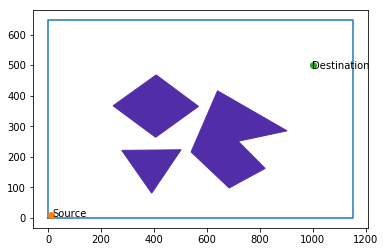

In [14]:
draw_problem(boundary, obstacles_basic, source, dest)

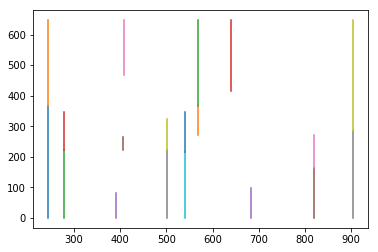

In [15]:
# draw_problem(boundary, obstacles_basic, source, dest)
#-----------------------------------------------------------
# Find vertical lines
# Make sure all the vertical line has the same x-value as the current vertex
open_line_segments = [];

for pt in new_sorted_vertices:
    curr_line_segment = [ point(pt.x, y_limit_lower), point(pt.x, y_limit_upper) ]; 
    lower_obs_pt = curr_line_segment[0];
    upper_obs_pt = curr_line_segment[1];
    # upper_gone is True if there is no line above the current vertex
    # lower_gone is True if there is no line below the current vertex
    upper_gone = False;
    lower_gone = False;
    # break_now is True if already find the vertical line
    break_now = False;
    
    intersections = []

    # Find intersection points with the vertical proposed lines. the intersection function returns false if segments are same, so no need to worry about same segment checking
    for index,obs in enumerate(new_obstacles):
        # Add the first point again for the last line segment of a polygon.
        obs.append( obs[0] );

        for vertex_index in range(len(obs)-1 ):
            # compare curr_line and segment from obstacle
            # check whether the two section is intersected or colinear
            # since the curr_line is the segment [point(pt.x, y_limit_lower), point(pt.x, y_limit_upper)], so that if the points are colinear, it must intersect
            # return the intersection point if the line intersect, and -1 if not.
            res = segment_intersection( curr_line_segment[0], curr_line_segment[1], obs[vertex_index],  obs[vertex_index+1])
            
            # if there is an intersection between current_line_seg and current obstacle edge
            if (res!=-1):
                # make sure the intersection has the same x-value as the current vertical line
                res.x = pt.x
                if pt.equals( res ) == False:
                    intersections.append(res)
    # among all the intersection from the current vertical line, choose the closest points that above or below the current vertex
    # For closest_lower point, if the point between it and the current vertex is in the obstacle, then lower_gone is True
    # For cloeset_upper point, if the point between it and the current vertex is in the obstacle, then upper_gone is True
    closest_lower, closest_upper = get_closest_intersection(pt, intersections)
    if(closest_lower != None):
        # check if the middle point pf current point and the intersection is inside theb polygon, lower_gone
        if centroid([pt, closest_lower]).inside_polygon(new_obstacles):
            lower_gone = True
        else:
            lower_obs_pt = closest_lower
    
    if(closest_upper != None):
        # check if the middle point pf current point and the intersection is inside theb polygon, lower_gone
        if centroid([pt, closest_upper]).inside_polygon(new_obstacles):
            upper_gone = True
        else:
            upper_obs_pt = closest_upper
        
    # Draw the vertical cell lines
    if(lower_gone is False):
        plt.plot( [lower_obs_pt.x, pt.x],  [lower_obs_pt.y, pt.y] )

    if(upper_gone is False):
        plt.plot( [pt.x, upper_obs_pt.x],  [pt.y, upper_obs_pt.y] )

    # Add to the global segment list
    if (lower_gone and upper_gone):
        open_line_segments.append([None, None])
    elif (lower_gone):
        open_line_segments.append([None, upper_obs_pt])
    elif (upper_gone):
        open_line_segments.append([lower_obs_pt, None])
    else:
        open_line_segments.append([lower_obs_pt, upper_obs_pt])

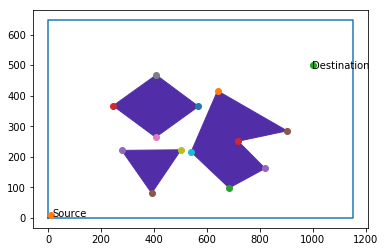

In [16]:
draw_problem(boundary, obstacles, source, dest)
#------------------------------------------------------
# Find Polygon cells naiively. Will improve next. 
# cells = []
# trapezoids = []
quad_cells = []
left_tri_cells = []
right_tri_cells = []
others = []
# open_line_segments and new_sorted_vertices has the same order of points, based on the x_value


# Important:
# Don't change the value of element in new_sorted_vertices and open_line_segments


for index1 in range(len(open_line_segments) ):
    curr_segment = open_line_segments[index1];
    curr_vertex = new_sorted_vertices[index1];
    plt.plot(curr_vertex.x, curr_vertex.y, marker='o')
    break_now = False;
    done = [False, False, True];

    # if the lower pt is the vertice
    # done[0] is True if there is no polygon below the vertex, or already get the lower polygon
    if( curr_segment[0] is None ):
        done[0] = True; 
    # if the upper vertice is the vertice
    # done[1] is True if there is no polygon above the vertex, or already get the upper polygon
    if( curr_segment[1] is None ):
        done[1] = True;
    # if both lower and upper pts are the vertice, which also means there is no vertical line through this line
    # if done[3] is True if there is no upper or lower polygon for this vertex and find the polygon for this vertex
    if( curr_segment[0] is None and curr_segment[1] is None):
        done[2] = False;

    # index2 the following sorted vertices
    for index2 in range(index1+1,  len(open_line_segments)):
        next_segment = open_line_segments[index2];
        next_vertex = new_sorted_vertices[index2];

        double_index1 = -2;
        double_index2 = -2;
        lines_to_check = [];
        
        double_check = False;

        # double_check is True if there are lines below and above the vertex
        if (next_segment[0] is not None and next_segment[1] is not None ):
            double_check = True;

        # if the lower pt isn't the vertice
        # check whether there is a polygon use the [current_vertex, current_segment[0]] as boundary
        if( done[0] is False ):
            if ( next_segment[0] is not None ):
                # check the upper polygon
                if(check_quad_polygon(curr_vertex, curr_segment[0], next_vertex, next_segment[0], new_obstacles)):
                    quad_cells.append([ curr_segment[0], next_segment[0], next_vertex, curr_vertex ])
                    done[0] = True
            
            if( next_segment[1] is not None ):
                # check the lower polygon
                if(check_quad_polygon(curr_vertex, curr_segment[0], next_vertex, next_segment[1], new_obstacles)):
                    quad_cells.append([ curr_segment[0], next_vertex, next_segment[1], curr_vertex ])
                    done[0] = True
                
            if(next_segment[0] is None and next_segment[1] is None):
                if(check_right_tri_polygon(curr_vertex, curr_segment[0], next_vertex, new_obstacles)):
                    right_tri_cells.append([ curr_segment[0], next_vertex, curr_vertex ])
                    done[0] = True
               
        # check whether there is a polygon use the [current_vertex, current_segment[1]] as boundary
        if( done[1] is False ):
            if ( next_segment[1] is not None ):
                # check the upper polygon
                if(check_quad_polygon(curr_vertex, curr_segment[1], next_vertex, next_segment[1], new_obstacles)):
#                     print("add")
                    quad_cells.append([ curr_vertex, next_vertex, next_segment[1], curr_segment[1] ])
                    done[1] = True
        
            if( next_segment[0] is not None ):
                # check the lower polygon
                if(check_quad_polygon(curr_vertex, curr_segment[1], next_vertex, next_segment[0], new_obstacles)):
#                     print("add")
                    quad_cells.append([ curr_vertex, next_segment[0], next_vertex , curr_segment[1]] )
                    done[1] = True
        
            if( next_segment[0] is None and next_segment[1] is None):
                if(check_right_tri_polygon(curr_vertex, curr_segment[1], next_vertex, new_obstacles)):
#                     print("add")
                    right_tri_cells.append([ curr_vertex, next_vertex, curr_segment[1] ])
                    done[1] = True

        
        if( done[2] is False ):
            if ( next_segment[0] is not None ):
                if(check_left_tri_polygon(curr_vertex, next_segment[0], next_vertex, new_obstacles)):
#                     print("add")
                    left_tri_cells.append([ curr_vertex,next_segment[0], next_vertex ])
                    done[2] = True
                    
            if( next_segment[1] is not None ):
                if(check_left_tri_polygon(curr_vertex, next_segment[1], next_vertex, new_obstacles)):
#                     print("add")
                    left_tri_cells.append([ curr_vertex, next_vertex, next_segment[1] ])
                    done[2] = True

        if( done[0] == True and done[1] == True and done[2] == True ):
            break;


In [17]:
#-------------------------------------------------------
# Merge overlapping Polygons
# quad_cells = [i for i in cells if len(i)>3]
# tri_cells = [i for i in cells if len(i)==3]
# others = [i for i in cells if len(i)<3]
quads_to_remove = []
quads_to_add = []

quads_to_remove = []
quads_to_add = []
for index_cell in range(len(quad_cells)):
    for index_cell2,cell in enumerate(quad_cells):
        if(index_cell != index_cell2):
            # if two quad_cell has the same x-direction location, then check wether they could merge
            if(quad_cells[index_cell][0].x == cell[0].x and quad_cells[index_cell][1].x == cell[1].x):
                    temp1 = list(quad_cells[index_cell])
                    temp1.append(temp1[0])
                    temp2 = list(cell)
                    temp2.append(temp2[0])
                    area1 = quad_polygon_area(temp1)
                    area2 = quad_polygon_area(temp2)
                    
                    # construct new polygon
                    new_quad=[];
                    new_quad.append( point(temp1[0].x, min(temp1[0].y, temp2[0].y)) )
                    new_quad.append( point(temp1[1].x, min(temp1[1].y, temp2[1].y)) )
                    new_quad.append( point(temp1[1].x, max(temp1[2].y, temp2[2].y)) )
                    new_quad.append( point(temp1[0].x, max(temp1[3].y, temp2[3].y)) )
                    area3 = quad_polygon_area(new_quad);
                    
                    if( area1 + area2 >= area3):
                        #merge
                        quads_to_remove.append(index_cell)
                        quads_to_remove.append(index_cell2)
                        quads_to_add.append(new_quad)
                        
# delete the duplicated index
quads_to_remove = list(set(quads_to_remove))
# generate the reversed array, so that deleting one element will not affect the element before
for index in sorted(quads_to_remove, reverse=True):
    del quad_cells[index];

for i in quads_to_add:
    quad_cells.append(i);

In [18]:
# # Remove duplicates
to_remove = [];
for index1 in range(len(quad_cells)):
    for index2 in range(index1+1, len(quad_cells)):
        duplicate = True;
        for k,m in zip(quad_cells[index1], quad_cells[index2]):
            if k.equals(m) is False:
                duplicate = False
                break
        if(duplicate is True):
            if index2 not in to_remove:
                to_remove.append(index2)

for index in sorted(to_remove, reverse=True):
    del quad_cells[index]


In [19]:
# One more pass to remove extra quads generated because of cross-intersection
quads_to_remove = [];
for index1 in range(len(quad_cells)):
    for index2 in range(len(quad_cells)):
        if(index1 != index2 and quad_cells[index1][0].x == quad_cells[index2][0].x and quad_cells[index1][1].x == quad_cells[index2][1].x):

            if( (quad_cells[index1][0].y<= quad_cells[index2][0].y) and  (quad_cells[index1][1].y<= quad_cells[index2][1].y)
                and (quad_cells[index1][2].y>= quad_cells[index2][2].y) and (quad_cells[index1][3].y >= quad_cells[index2][3].y)):
                quads_to_remove.append(index2)


quads_to_remove = list(set(quads_to_remove))
for index in sorted(quads_to_remove, reverse=True):
    del quad_cells[index];


In [20]:
# ------------------------------------------------------
# Add boundary lines
if( boundary[0].x != new_sorted_vertices[0].x):
    quad_cells.append([boundary[0], point(new_sorted_vertices[0].x, y_limit_lower), point(new_sorted_vertices[0].x, y_limit_upper), boundary[3]]);
if( boundary[1].x != new_sorted_vertices[len(new_sorted_vertices)-1].x):
    quad_cells.append([point(new_sorted_vertices[len(new_sorted_vertices)-1].x ,y_limit_lower), boundary[1], boundary[2], point(new_sorted_vertices[len(new_sorted_vertices)-1].x, y_limit_upper)]);


17
polygon:  0
x = 0, y = 0, obs = -1 and test:-1
x = 245, y = 0, obs = -1 and test:-1
x = 245, y = 647, obs = -1 and test:-1
x = 0, y = 647, obs = -1 and test:-1
polygon:  1
x = 245, y = 367, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 408, y = 647, obs = -1 and test:-1
x = 245, y = 647, obs = -1 and test:-1
polygon:  2
x = 245, y = 0, obs = -1 and test:-1
x = 278, y = 0, obs = -1 and test:-1
x = 278, y = 346, obs = -1 and test:-1
x = 245, y = 367, obs = -1 and test:-1
polygon:  3
x = 278, y = 0, obs = -1 and test:-1
x = 391, y = 0, obs = -1 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 278, y = 221, obs = 2 and test:-1
polygon:  4
x = 278, y = 221, obs = 2 and test:-1
x = 406, y = 222, obs = -1 and test:-1
x = 406, y = 264, obs = 0 and test:-1
x = 278, y = 346, obs = -1 and test:-1
polygon:  5
x = 391, y = 0, obs = -1 and test:-1
x = 502, y = 0, obs = -1 and test:-1
x = 502, y = 223, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
polygon:  6
x = 406

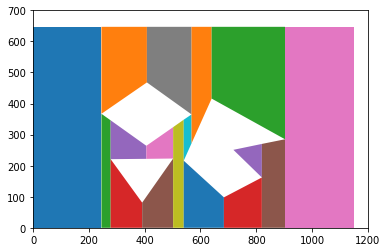

In [21]:
#-------------------------------------------------------
# Plot final cells
all_cell = quad_cells + left_tri_cells + right_tri_cells + others

# sort the cell based on teh x-value of the first point
all_cell.sort(key = lambda pnt: pnt[0].x)
print(len(all_cell))
for index, i in enumerate(all_cell):
    x = [j.x for j in i]
    x.append(x[0])
    y = [j.y for j in i]
    y.append(y[0])
#     plt.figure(index)
    plt.xlim(0,1200)
    plt.ylim(0,700)
    plt.fill(x, y);
    print("polygon: ", index)
    for x in i:
        print(x)

polygon:  0
x = 0, y = 0, obs = -1 and test:-1
x = 245, y = 0, obs = -1 and test:-1
x = 245, y = 647, obs = -1 and test:-1
x = 0, y = 647, obs = -1 and test:-1
polygon:  1
x = 245, y = 367, obs = 0 and test:-1
x = 408, y = 468, obs = 0 and test:-1
x = 408, y = 647, obs = -1 and test:-1
x = 245, y = 647, obs = -1 and test:-1
polygon:  2
x = 245, y = 0, obs = -1 and test:-1
x = 278, y = 0, obs = -1 and test:-1
x = 278, y = 346, obs = -1 and test:-1
x = 245, y = 367, obs = -1 and test:-1
polygon:  3
x = 278, y = 0, obs = -1 and test:-1
x = 391, y = 0, obs = -1 and test:-1
x = 391, y = 81, obs = 2 and test:-1
x = 278, y = 221, obs = 2 and test:-1
polygon:  4
x = 278, y = 221, obs = 2 and test:-1
x = 406, y = 222, obs = -1 and test:-1
x = 406, y = 264, obs = 0 and test:-1
x = 278, y = 346, obs = -1 and test:-1
polygon:  5
x = 391, y = 0, obs = -1 and test:-1
x = 502, y = 0, obs = -1 and test:-1
x = 502, y = 223, obs = 2 and test:-1
x = 391, y = 81, obs = 2 and test:-1
polygon:  6
x = 406, y

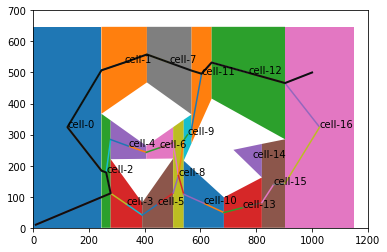

In [22]:
#-------------------------------------------------------
# Plot final cells
for index, i in enumerate(all_cell):
    x = [j.x for j in i]
    y = [j.y for j in i]
#     plt.figure(index)
    plt.xlim(0,1200)
    plt.ylim(0,700)
    plt.fill(x, y);
    center = centroid(i)
    plt.plot(center.x, center.y, marker="o")
    plt.annotate('cell-{}'.format(index), xy=(center.x, center.y))
    print("polygon: ", index)
    for x in i:
        print(x)

#----------------------------------------------------------------------
# Get the graph
graph_vertices = [];
graph_edges = [];

for index1 in range(len(quad_cells)):
    same_boundary = [];
    # find the quad_cells that have the overlapping boundary
    for index2 in range(len(quad_cells)):
        if(index1 != index2):
            if( (quad_cells[index1][1].x == quad_cells[index2][0].x )
               # if two segments have overlapping, then the sum of length of two individual segments should be larger than the connected line
               and ((max(quad_cells[index1][1].y, quad_cells[index1][2].y, quad_cells[index2][0].y, quad_cells[index2][3].y) - 
                     min(quad_cells[index1][1].y, quad_cells[index1][2].y, quad_cells[index2][0].y, quad_cells[index2][3].y)) < 
                    (abs(quad_cells[index1][2].y - quad_cells[index1][1].y) + 
                     abs(quad_cells[index2][3].y - quad_cells[index2][0].y)))):
                same_boundary.append(index2)

    temp = quad_cells[index1][0:4]
    centroid_vertex = centroid(temp)
    place = centroid_vertex.find_point(graph_vertices)
    if( place == -1):
        graph_vertices.append(centroid_vertex)

    if(len(same_boundary)==1):
        
        # if there is only one cell that has the overlapping boundary, use the middle point of current cell
        temp_edge_middle = centroid([quad_cells[index1][1], quad_cells[index1][2]])
        graph_vertices.append(temp_edge_middle)
        n = len(graph_vertices)-1;
        if(place != -1):
            graph_edges.append([place, n])
        else:
            graph_edges.append([n-1, n])
        temp = quad_cells[same_boundary[0]][0:4]
        curr_centroid_vertex = centroid(temp)
        place2 = curr_centroid_vertex.find_point(graph_vertices)
        if( place2 == -1 ):
            graph_vertices.append(curr_centroid_vertex)
            graph_edges.append([n, n+1])
        else:
            graph_edges.append([n, place2])

    elif(len(same_boundary)>1):
        n = len(graph_vertices)-1
        if(place != -1):
            use = place
        else:
            use = n
        for index, i in enumerate(same_boundary):
            temp = quad_cells[i][0:4];
            curr_centroid_vertex = centroid(temp)
            
            # if there is only one cell that has the overlapping boundary, use the middle point of adjacent cell
            temp_edge_middle = centroid([quad_cells[i][0], quad_cells[i][3]]);
            graph_vertices.append(temp_edge_middle)
            pl1 =len(graph_vertices)-1;
            graph_edges.append([use, pl1])
            hmmm= curr_centroid_vertex.find_point(graph_vertices);
            if (hmmm == -1):
                graph_vertices.append(curr_centroid_vertex);
                pl2 =len(graph_vertices)-1
            else:
                pl2 = hmmm;
            graph_edges.append([pl1, pl2])


# Add source and dest to graph
# Find the smallest distance vertex on graph and see if its clear to traverse
# Source------------------------------
min_ind = -1; min_value = 9999999;
for index, i in enumerate(graph_vertices):
    if( check_obstruction(new_obstacles, [source, i]) is True ):
        dist = find_dist(i, source);
        if( dist < min_value):
            min_value = dist;
            min_ind = index;

graph_vertices.append(source);
m = len(graph_vertices)-1;
graph_edges.append([min_ind, m]);

# Destination------------------------------------
min_ind = -1; min_value = 9999999;
for index, i in enumerate(graph_vertices):
    if( check_obstruction(new_obstacles, [dest, i]) is True ):
        dist = find_dist(i, dest);
        if( dist < min_value):
            min_value = dist;
            min_ind = index;

graph_vertices.append(dest);
m = len(graph_vertices)-1;
graph_edges.append([min_ind, m]);

# Convert graph in adjacency list format
graph = [];
for j in range(len(graph_vertices)):
    graph.append([]);
    for i in graph_edges:
        if(i[0]==j):
            graph[j].append(i[1]);
        elif(i[1]==j):
            graph[j].append(i[0]);

path = bfs(graph, len(graph_vertices)-2, len(graph_vertices)-1);

if(path is None):
    print("No path found. Sorry");
    sys.exit();
else:
    print("Path found.");

# Draw everything--------------
# for index,i in enumerate(graph_vertices):
#     plt.annotate(str(index), xy=(i.x, i.y), xytext=(i.x+2, i.y-2) );
    # plt.plot(i.x,i.y, marker="x");

for i in graph_edges:
    temp_x = [graph_vertices[i[0]].x, graph_vertices[i[1]].x];
    temp_y = [graph_vertices[i[0]].y, graph_vertices[i[1]].y];
    plt.plot(temp_x,temp_y);


# draw path
temp_x = [graph_vertices[i].x for i in path]
temp_y = [graph_vertices[i].y for i in path]
plt.plot(temp_x,temp_y, color="#0F0F0F", linewidth=2)

In [25]:
nodes = []
# define the type
# 1: quad_cell
# 2: left_tri_cell: left side has only one point
# 3: right_tri_cell: right side has only one point
for index, cell in enumerate(all_cell):
    if(len(cell)) == 4:
        nodes.append(node(index, cell, 1))
    elif(len(cell) == 3 and cell[1].x == cell[2].x):
        nodes.append(node(index, cell, 2))
    elif(len(cell) == 3 and cell[0].x == cell[2].x):
        nodes.append(node(index, cell, 3))
#     print("{}-th polygon:\n\ttype: {}\n\tcentroid: {}".format(index, nodes[index].type, nodes[index].centroid))
    
for curr_node in nodes:
    for next_node in nodes:
        if(next_node.index != curr_node.index):
            # define the type
            # 1: quad_cell
            # 2: left_tri_cell: left side has only one point
            # 3: right_tri_cell: right side has only one point
            if((curr_node.type == 1 or curr_node.type == 2) and 
                (next_node.type == 1 or next_node.type == 3)):
                if(curr_node.polygon[1].x == next_node.polygon[0].x):
                    if( (max(curr_node.polygon[2].y, next_node.polygon[-1].y) - min(curr_node.polygon[1].y, next_node.polygon[0].y)) 
                         < (abs(curr_node.polygon[2].y - curr_node.polygon[1].y) + abs(next_node.polygon[-1].y - next_node.polygon[0].y)) ):
                        curr_node.add_adjacent(next_node)
    total_adjacent = curr_node.get_adjacent();
    if(len(total_adjacent) == 1):
        curr_node.add_middle_point(centroid([curr_node.polygon[1], curr_node.polygon[2]]))

    elif(len(total_adjacent) >= 1):
        for ad_node in total_adjacent:
            curr_node.add_middle_point(centroid([ad_node.polygon[0], ad_node.polygon[-1]]))
    curr_node.calculate_distance()
    


Current node index: 0
Adjacent node index: 1	distance: 304
Adjacent node index: 2	distance: 203

Current node index: 1
Adjacent node index: 7	distance: 169

Current node index: 2
Adjacent node index: 3	distance: 134
Adjacent node index: 4	distance: 174

Current node index: 3
Adjacent node index: 5	distance: 132

Current node index: 4
Adjacent node index: 6	distance: 117

Current node index: 5
Adjacent node index: 8	distance: 124

Current node index: 6
Adjacent node index: 8	distance: 157

Current node index: 7
Adjacent node index: 11	distance: 121

Current node index: 8
Adjacent node index: 9	distance: 137
Adjacent node index: 10	distance: 139

Current node index: 9
Adjacent node index: 11	distance: 203

Current node index: 10
Adjacent node index: 13	distance: 147

Current node index: 11
Adjacent node index: 12	distance: 186

Current node index: 12
Adjacent node index: 16	distance: 323

Current node index: 13
Adjacent node index: 15	distance: 140

Current node index: 14
Adjacent node 

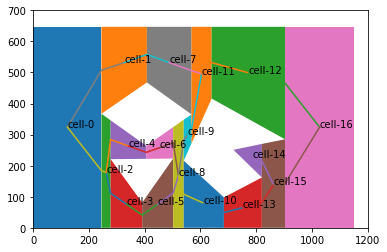

In [32]:
#-------------------------------------------------------
# Plot final cells
for index, i in enumerate(all_cell):
    x = [j.x for j in i]
    y = [j.y for j in i]
#     plt.figure(index)
    plt.xlim(0,1200)
    plt.ylim(0,700)
    plt.fill(x, y);
    center = centroid(i)
    plt.plot(center.x, center.y, marker="o")
    plt.annotate('cell-{}'.format(index), xy=(center.x, center.y))
#     print("polygon: ", index)
#     for x in i:
#         print(x)



for curr_node in nodes:
    print("\nCurrent node index: {}".format(curr_node.index))
    for index, ad_node in enumerate(curr_node.get_adjacent()):
        print("Adjacent node index: {}\tdistance: {}".format(ad_node.index, curr_node.get_distance()[index]))
        x = [curr_node.centroid.x, curr_node.get_middle_point()[index].x, ad_node.centroid.x]
        y = [curr_node.centroid.y, curr_node.get_middle_point()[index].y, ad_node.centroid.y]
        plt.plot(x, y)
#         print("Adjacent node index: {}".format(ad_node.index))
#         print(curr_node.get_middle_point()[index])